In [1]:
import argparse
import os
#from savedir import *
#from utils import *
import numpy as np
import pandas as pd 
import copy

import torch
from torch import nn
import torch.nn.functional as nnf
import torch.optim as torchopt
import torch.distributions.constraints as constraints
softplus = torch.nn.Softplus()

import pyro
from pyro import poutine
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO, Predictive
import pyro.optim as pyroopt
from pyro.infer.mcmc import MCMC, HMC, NUTS
from pyro.distributions import OneHotCategorical, Normal, Categorical, Uniform
from pyro.nn import PyroModule

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

import random

/home/thomas/miniconda3/envs/tyxe_lorzo/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
DEBUG = False

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))
if torch.cuda.is_available():
        torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
        torch.set_default_tensor_type('torch.FloatTensor')

Device: cuda:0


In [4]:
def plot_loss_accuracy(dict, path):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(12,8))
    ax1.plot(dict['loss'])
    ax1.set_title("loss")
    ax2.plot(dict['accuracy'])
    ax2.set_title("accuracy")
#    os.makedirs(os.path.dirname(path), exist_ok=True)
#    fig.savefig(path)

In [5]:
class NN(nn.Module):

    def __init__(self, dataset_name, input_shape, output_size, activation, 
                 architecture, lr, epochs):

#        if math.log(hidden_size, 2).is_integer() is False or hidden_size<16:
#            raise ValueError("\nhidden size should be a power of 2 greater than 16.")

        super(NN, self).__init__()
        self.dataset_name = dataset_name
        self.loss_func = nn.CrossEntropyLoss()
        # self.loss_func = nn.NLLLoss()
        self.architecture = architecture
#        self.hidden_size = hidden_size
        self.output_size = output_size
        self.activation = activation
        self.lr, self.epochs = lr, epochs

#        self.name = self.get_name(dataset_name, hidden_size, activation, architecture, lr, epochs)
        self.set_model(architecture, activation, input_shape, output_size)
        # print("\nTotal number of weights =", sum(p.numel() for p in self.parameters()))

    def get_name(self, dataset_name, activation, architecture, lr, epochs):
        return str(dataset_name)+"_act="+str(activation)+\
               "_arch="+str(architecture)+"_ep="+str(epochs)+"_lr="+str(lr)

    def set_model(self, architecture, activation, input_shape, output_size):

        input_size = input_shape[0]*input_shape[1]*input_shape[2]
        in_channels = input_shape[0]
        n_classes = output_size

        if activation == "relu":
            activ = nn.ReLU
        elif activation == "leaky":
            activ = nn.LeakyReLU
        elif activation == "sigm":
            activ = nn.Sigmoid
        elif activation == "tanh":
            activ = nn.Tanh
        else: 
            raise AssertionError("\nWrong activation name.")

        if architecture == "fc":
            self.model = nn.Sequential(
                nn.Flatten(),
                nn.Linear(input_size, 100),
                activ(),
                nn.Linear(100, output_size))
            
        elif architecture == "custom":
            self.model = nn.Sequential(nn.Conv2d(in_channels= in_channels,
                                                 out_channels=64,
                                                 kernel_size=5,
                                                 ),
                                       activ(),
                                       nn.MaxPool2d(2,2),
                                       #nn.BatchNorm2d(64),
                                       nn.Conv2d(in_channels=64,
                                                 out_channels=512,
                                                 kernel_size=3,
                                                 ),
                                       activ(),
                                       nn.MaxPool2d(2,2),
                                       #nn.Dropout(p=0.3),
                                       #nn.Conv2d(in_channels=512,
                                       #          out_channels=1024,
                                       #          kernel_size=3,
                                       #          ),
                                       #activ(),
                                       #nn.MaxPool2d(2,2),
                                       #nn.BatchNorm2d(1024),
                                       #nn.Dropout(p=0.4),
                                       #nn.Conv2d(in_channels=1024,
                                       #          out_channels=1024,
                                       #          kernel_size=2,
                                       #          ),
                                       #activ(),
                                       #nn.MaxPool2d(2,2),
                                       #nn.Dropout(p=0.4),
                                       nn.Flatten(),
                                       nn.Linear(512*5*5, 256),
                                       #nn.Dropout(p=0.5),
                                       nn.Linear(256, output_size))

        elif architecture == "conv":

            if self.dataset_name not in ["mnist","fashion_mnist"]:
                raise NotImplementedError()

            self.model = nn.Sequential(
                nn.Conv2d(in_channels, 32, kernel_size=5),
                activ(),
                nn.MaxPool2d(kernel_size=2),
                nn.Conv2d(32, hidden_size, kernel_size=5),
                activ(),
                nn.MaxPool2d(kernel_size=2, stride=1),
                nn.Flatten(),
                nn.Linear(int(hidden_size/(4*4))*input_size, output_size))

        elif architecture == "conv2":

            self.model = nn.Sequential(

                nn.Conv2d(in_channels, 32, kernel_size=5),
                activ(),
                nn.MaxPool2d(kernel_size=2), 
                nn.Conv2d(32, hidden_size, kernel_size=5),
                activ(),
                nn.MaxPool2d(kernel_size=2, stride=1),
                nn.Flatten(),
            )   

            self.fc_out = lambda x: nn.Linear(x.size(1), output_size)(x)

        else:
            raise NotImplementedError()

    def forward(self, inputs, device=None, *args, **kwargs):

        device=self.device if device is None else device

        self.to(device)
        inputs = inputs.to(device)

        if self.architecture == "conv2":

            x = self.model(inputs)
            x = self.fc_out(x)

        else:
            x = self.model(inputs)

        return x

    def save(self, savedir=None, seed=None):

        name = self.name 
        directory = name if savedir is None else savedir
        filename = name+"_weights.pt" if seed is None else name+"_weights_"+str(seed)+".pt"

        os.makedirs(os.path.dirname(TESTS+directory+"/"), exist_ok=True)
        print("\nSaving: ", TESTS+directory+"/"+filename)
        torch.save(self.state_dict(), TESTS+directory+"/"+filename)

        if DEBUG:
            print("\nCheck saved weights:")
            print("\nstate_dict()['l2.0.weight'] =", self.state_dict()["l2.0.weight"][0,0,:3])
            print("\nstate_dict()['out.weight'] =",self.state_dict()["out.weight"][0,:3])

    def load(self, device, savedir=None, seed=None, rel_path = None):   #=TESTS
        self.device=device

        name = self.name
        directory = name if savedir is None else savedir
        filename = name+"_weights.pt" if seed is None else name+"_weights_"+str(seed)+".pt"

        print("\nLoading: ", rel_path+directory+"/"+filename)
        self.load_state_dict(torch.load(rel_path+directory+"/"+filename))
        print("\n", list(self.state_dict().keys()), "\n")
        self.to(device)

        if DEBUG:
            print("\nCheck loaded weights:")    
            print("\nstate_dict()['l2.0.weight'] =", self.state_dict()["l2.0.weight"][0,0,:3])
            print("\nstate_dict()['out.weight'] =",self.state_dict()["out.weight"][0,:3])

    def train(self, train_loader, device, seed=0, save=True):

        print("\n == NN training ==")

        self.device=device
        self.to(device)

        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

        optimizer = torchopt.Adam(params=self.parameters(), lr=self.lr)

#        start = time.time()
        for epoch in range(self.epochs):
            total_loss = 0.0
            correct_predictions = 0.0

            for x_batch, y_batch in train_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device).argmax(-1)
                
                optimizer.zero_grad()
                outputs = self.forward(x_batch, device)
                loss = self.loss_func(outputs, y_batch)
                loss.backward()
                optimizer.step()

                predictions = outputs.argmax(-1)
                correct_predictions += (predictions == y_batch).sum()
                total_loss += loss.item()

            total_loss = total_loss / len(train_loader.dataset)
            accuracy = 100 * correct_predictions / len(train_loader.dataset)
            print(f"\n[Epoch {epoch + 1}]\t loss: {total_loss:.8f} \t accuracy: {accuracy:.2f}", 
                  end="\t")

#        execution_time(start=start, end=time.time())
        
        if save:
            self.save()

    def evaluate(self, test_loader, device, *args, **kwargs):
        self.device=device
        self.to(device)

        with torch.no_grad():

            correct_predictions = 0.0

            for x_batch, y_batch in test_loader:

                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device).argmax(-1)
                outputs = self(x_batch)
                predictions = outputs.argmax(-1)
                correct_predictions += (predictions == y_batch).sum()

            accuracy = 100 * correct_predictions / len(test_loader.dataset)
            print("\nAccuracy: %.2f%%" % (accuracy))
            return accuracy

In [6]:
class BNN(PyroModule):

    def __init__(self, dataset_name, activation, architecture, inference, 
                 epochs, lr, n_samples, warmup, input_shape, output_size, 
                 step_size=0.005, num_steps=10):
        super(BNN, self).__init__()
        self.dataset_name = dataset_name
        self.inference = inference
        self.architecture = architecture
        self.epochs = epochs
        self.lr = lr
        self.n_samples = n_samples
        self.warmup = warmup
        self.step_size = step_size
        self.num_steps = num_steps
        self.basenet = NN(dataset_name=dataset_name, input_shape=input_shape, output_size=output_size,
                          activation=activation, architecture=architecture, epochs=epochs, lr=lr)
        # print(self.basenet)
        self.name = self.get_name()

    def get_name(self, n_inputs=None):
        
        name = str(self.dataset_name)+"_bnn_"+str(self.inference)+"_act="+str(self.basenet.activation)+\
               "_arch="+str(self.basenet.architecture)

        if n_inputs:
            name = name+"_inp="+str(n_inputs)

        if self.inference == "svi":
            return name+"_ep="+str(self.epochs)+"_lr="+str(self.lr)
        elif self.inference == "hmc":
            return name+"_samp="+str(self.n_samples)+"_warm="+str(self.warmup)+\
                   "_stepsize="+str(self.step_size)+"_numsteps="+str(self.num_steps)

    def model(self, x_data, y_data):

        priors = {}
        for key, value in self.basenet.state_dict().items():
            loc = torch.zeros_like(value)
            scale = torch.ones_like(value)
            prior = Normal(loc=loc, scale=scale)
            priors.update({str(key):prior})

        lifted_module = pyro.random_module("module", self.basenet, priors)()

        with pyro.plate("data", len(x_data)):
            logits = lifted_module(x_data)
            lhat = nnf.log_softmax(logits, dim=-1)
            obs = pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

    def guide(self, x_data, y_data=None):

        dists = {}
        for key, value in self.basenet.state_dict().items():
            loc = pyro.param(str(f"{key}_loc"), torch.randn_like(value)) 
            scale = pyro.param(str(f"{key}_scale"), torch.randn_like(value))
            distr = Normal(loc=loc, scale=softplus(scale))
            dists.update({str(key):distr})

        lifted_module = pyro.random_module("module", self.basenet, dists)()
        
        with pyro.plate("data", len(x_data)):
            logits = lifted_module(x_data)
            preds = nnf.softmax(logits, dim=-1)

        return preds

    def save(self, rel_path = None, filename=None):    #=TESTS

        if filename is None:
            filename = self.name+"_weights"

        path = rel_path + self.name +"/"
        os.makedirs(os.path.dirname(path), exist_ok=True)

        if self.inference == "svi":
            self.basenet.to("cpu")
            self.to("cpu")

            param_store = pyro.get_param_store()
            print("\nSaving: ", path + filename +".pt")
            print(f"\nlearned params = {param_store.get_all_param_names()}")
            param_store.save(path + filename +".pt")

        elif self.inference == "hmc":
            self.basenet.to("cpu")
            self.to("cpu")

            for key, value in self.posterior_predictive.items():
                torch.save(value.state_dict(), path+filename+"_"+str(key)+".pt")

                if DEBUG:
                    print(value.state_dict()["model.5.bias"])

    def load(self, device, rel_path = None, filename=None):     #=TESTS

        if filename is None:
            filename = self.name+"_weights"

        path = rel_path + self.name +"/"

        self.device=device
        self.basenet.device=device

        if self.inference == "svi":
            param_store = pyro.get_param_store()
            param_store.load(path + filename + ".pt")
            for key, value in param_store.items():
                param_store.replace_param(key, value.to(device), value)
            print("\nLoading ", path + filename + ".pt\n")

        elif self.inference == "hmc":

            self.posterior_predictive={}
            for model_idx in range(self.n_samples):
                net_copy = copy.deepcopy(self.basenet)
                net_copy.load_state_dict(torch.load(path+filename+"_"+str(model_idx)+".pt"))
                self.posterior_predictive.update({model_idx:net_copy})      

            if len(self.posterior_predictive)!=self.n_samples:
                raise AttributeError("wrong number of posterior models")

        self.to(device)
        self.basenet.to(device)

    def forward(self, inputs, n_samples=10, avg_posterior=False, seeds=None):

        if seeds:
            if len(seeds) != n_samples:
                raise ValueError("Number of seeds should match number of samples.")

        if self.inference == "svi":

            if avg_posterior is True:

                guide_trace = poutine.trace(self.guide).get_trace(inputs)  

                avg_state_dict = {}
                for key in self.basenet.state_dict().keys():
                    avg_weights = guide_trace.nodes[str(key)+"_loc"]['value']
                    avg_state_dict.update({str(key):avg_weights})

                self.basenet.load_state_dict(avg_state_dict)
                preds = [self.basenet.model(inputs)]

            else:

                preds = []  

                if seeds:
                    for seed in seeds:
                        pyro.set_rng_seed(seed)
                        guide_trace = poutine.trace(self.guide).get_trace(inputs)   
                        preds.append(guide_trace.nodes['_RETURN']['value'])

                else:

                    for _ in range(n_samples):
                        guide_trace = poutine.trace(self.guide).get_trace(inputs)   
                        preds.append(guide_trace.nodes['_RETURN']['value'])

                if DEBUG:
                    print("\nlearned variational params:\n")
                    print(pyro.get_param_store().get_all_param_names())
                    print(list(poutine.trace(self.guide).get_trace(inputs).nodes.keys()))
                    print("\n", pyro.get_param_store()["model.0.weight_loc"][0][:5])
                    print(guide_trace.nodes['module$$$model.0.weight']["fn"].loc[0][:5])
                    print("posterior sample: ", 
                      guide_trace.nodes['module$$$model.0.weight']['value'][5][0][0])

        elif self.inference == "hmc":

            preds = []
            posterior_predictive = list(self.posterior_predictive.values())

            if seeds is None:
                seeds = range(n_samples)

            for seed in seeds:
                net = posterior_predictive[seed]
                preds.append(net.forward(inputs))
    
        output_probs = torch.stack(preds).mean(0)
        return output_probs 

    def _train_hmc(self, train_loader, n_samples, warmup, step_size, num_steps, device, rel_path, filename):

        print("\n == HMC training ==")
        pyro.clear_param_store()

        num_batches = int(len(train_loader.dataset)/train_loader.batch_size)
        batch_samples = int(n_samples/num_batches)+1
        print("\nn_batches=",num_batches,"\tbatch_samples =", batch_samples)

        kernel = HMC(self.model, step_size=step_size, num_steps=num_steps)
        mcmc = MCMC(kernel=kernel, num_samples=batch_samples, warmup_steps=warmup, num_chains=1)

#        start = time.time()
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            labels = y_batch.to(device).argmax(-1)
            mcmc.run(x_batch, labels)

#        execution_time(start=start, end=time.time())     

        self.posterior_predictive={}
        posterior_samples = mcmc.get_samples(n_samples)
        state_dict_keys = list(self.basenet.state_dict().keys())

        if DEBUG:
            print("\n", list(posterior_samples.values())[-1])

        for model_idx in range(n_samples):
            net_copy = copy.deepcopy(self.basenet)

            model_dict=OrderedDict({})
            for weight_idx, weights in enumerate(posterior_samples.values()):
                model_dict.update({state_dict_keys[weight_idx]:weights[model_idx]})
            
            net_copy.load_state_dict(model_dict)
            self.posterior_predictive.update({str(model_idx):net_copy})

        if DEBUG:
            print("\n", weights[model_idx]) 

        self.save(rel_path=rel_path, filename=filename)

    def _train_svi(self, train_loader, epochs, lr, device, rel_path, filename):     # filename -> savedir
        self.device=device

        print("\n == SVI training ==")

        optimizer = pyro.optim.Adam({"lr":lr})
        elbo = TraceMeanField_ELBO()
        svi = SVI(self.model, self.guide, optimizer, loss=elbo)

        loss_list = []
        accuracy_list = []

#        start = time.time()
        for epoch in range(epochs):
            loss = 0.0
            correct_predictions = 0.0

            for x_batch, y_batch in train_loader:

                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                labels = y_batch.argmax(-1)
                loss += svi.step(x_data=x_batch, y_data=labels)

                outputs = self.forward(x_batch, n_samples=10)
                predictions = outputs.argmax(dim=-1)
                correct_predictions += (predictions == labels).sum().item()
            
            if DEBUG:
                print("\n", pyro.get_param_store()["model.0.weight_loc"][0][:5])
                print("\n", predictions[:10], "\n", labels[:10])

            total_loss = loss / len(train_loader.dataset)
            accuracy = 100 * correct_predictions / len(train_loader.dataset)

            print(f"\n[Epoch {epoch + 1}]\t loss: {total_loss:.2f} \t accuracy: {accuracy:.2f}", 
                  end="\t")

            loss_list.append(loss)
            accuracy_list.append(accuracy)

#        execution_time(start=start, end=time.time())
#        self.save(rel_path=rel_path, filename=filename)

        plot_loss_accuracy(dict={'loss':loss_list, 'accuracy':accuracy_list},
                           path = None)   # TESTS+self.name+"/"+self.name+"_training.png"

    def train(self, train_loader, device, rel_path = None, filename=None):   #=TESTS
        self.device=device
        self.basenet.device=device

        self.to(device)
        self.basenet.to(device)

        random.seed(0)
        pyro.set_rng_seed(0)

        if self.inference == "svi":
            self._train_svi(train_loader, self.epochs, self.lr, device, rel_path=rel_path, filename=filename)

        elif self.inference == "hmc":
            self._train_hmc(train_loader, self.n_samples, self.warmup,
                            self.step_size, self.num_steps, device, rel_path=rel_path, filename=filename)

    def evaluate(self, test_loader, device, n_samples=10, seeds_list=None):
        self.device=device
        self.basenet.device=device
        self.to(device)
        self.basenet.to(device)

        random.seed(0)
        pyro.set_rng_seed(0)

        bnn_seeds=list(range(n_samples)) if seeds_list is None else seeds_list

        with torch.no_grad():

            correct_predictions = 0.0
            for x_batch, y_batch in test_loader:

                x_batch = x_batch.to(device)
                outputs = self.forward(x_batch, n_samples=n_samples, seeds=bnn_seeds)
                predictions = outputs.argmax(-1)
                labels = y_batch.to(device).argmax(-1)
                correct_predictions += (predictions == labels).sum().item()

            accuracy = 100 * correct_predictions / len(test_loader.dataset)
            print("Accuracy: %.2f%%" % (accuracy))
            return accuracy

In [7]:
data = pd.read_csv("data/sign_mnist_train.csv")

24


<AxesSubplot:ylabel='Frequency'>

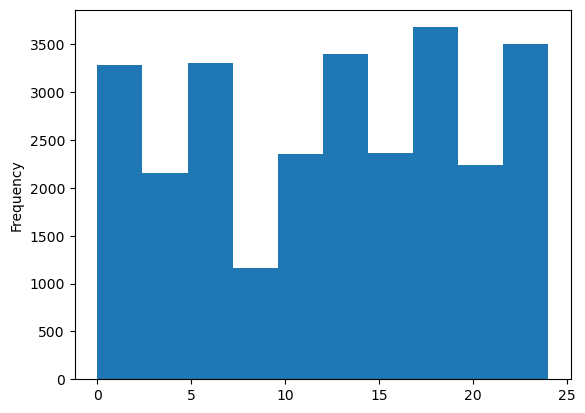

In [8]:
n_classes = data["label"].nunique()
print(n_classes)
data["label"].plot.hist()

In [9]:
y_train = data["label"]
X_train = data.drop(columns =["label"])

In [10]:
# DATA PARSER AND LOADER FOR THE VALUES OF SKIN
class HandSignsDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = np.asarray(images).astype(np.float32)
        self.y = labels
        self.transforms = transforms
        #print("GUARDA QUI", self.y.shape)
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X[i, :]
        data = data.reshape(28, 28, 1)
       
        my_y = self.y.values[i]
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, my_y)
        else:
            return data

In [11]:
y_train = pd.get_dummies(y_train)
X_train = X_train / 255
print(X_train)

         pixel1    pixel2    pixel3    pixel4    pixel5    pixel6    pixel7  \
0      0.419608  0.462745  0.498039  0.525490  0.545098  0.560784  0.572549   
1      0.607843  0.615686  0.611765  0.611765  0.611765  0.615686  0.611765   
2      0.733333  0.737255  0.737255  0.733333  0.733333  0.729412  0.733333   
3      0.827451  0.827451  0.831373  0.831373  0.827451  0.823529  0.827451   
4      0.643137  0.654902  0.666667  0.674510  0.690196  0.701961  0.705882   
...         ...       ...       ...       ...       ...       ...       ...   
27450  0.741176  0.741176  0.745098  0.745098  0.752941  0.756863  0.756863   
27451  0.592157  0.603922  0.615686  0.619608  0.627451  0.631373  0.639216   
27452  0.682353  0.682353  0.682353  0.682353  0.682353  0.686275  0.686275   
27453  0.694118  0.709804  0.721569  0.725490  0.733333  0.741176  0.745098   
27454  0.701961  0.705882  0.705882  0.705882  0.713725  0.709804  0.713725   

         pixel8    pixel9   pixel10  ...  pixel775 

In [12]:
transform = transforms.Compose([ transforms.ToTensor(),
                                 transforms.Normalize(mean = 0.5, std = 0.5)])


train_data = HandSignsDataset(X_train, y_train, transform)
#test_data = HandSignsDataset(X_test, y_test, transform)
print(train_data)

In [13]:
generator = torch.Generator(device=device)

In [14]:
# dataloaders
trainloader = DataLoader(train_data, batch_size=180, shuffle=True, generator=generator)
#testloader = DataLoader(test_data, batch_size=8, shuffle=True)

In [15]:
np.asarray(train_data.X).astype(np.float32)

array([[0.41960785, 0.4627451 , 0.49803922, ..., 0.8       , 0.79607844,
        0.7921569 ],
       [0.60784316, 0.6156863 , 0.6117647 , ..., 0.40392157, 0.5294118 ,
        0.58431375],
       [0.73333335, 0.7372549 , 0.7372549 , ..., 0.7647059 , 0.7607843 ,
        0.7647059 ],
       ...,
       [0.68235296, 0.68235296, 0.68235296, ..., 0.7921569 , 0.78431374,
        0.78431374],
       [0.69411767, 0.70980394, 0.72156864, ..., 0.2509804 , 0.34117648,
        0.3647059 ],
       [0.7019608 , 0.7058824 , 0.7058824 , ..., 0.8039216 , 0.81960785,
        0.84313726]], dtype=float32)

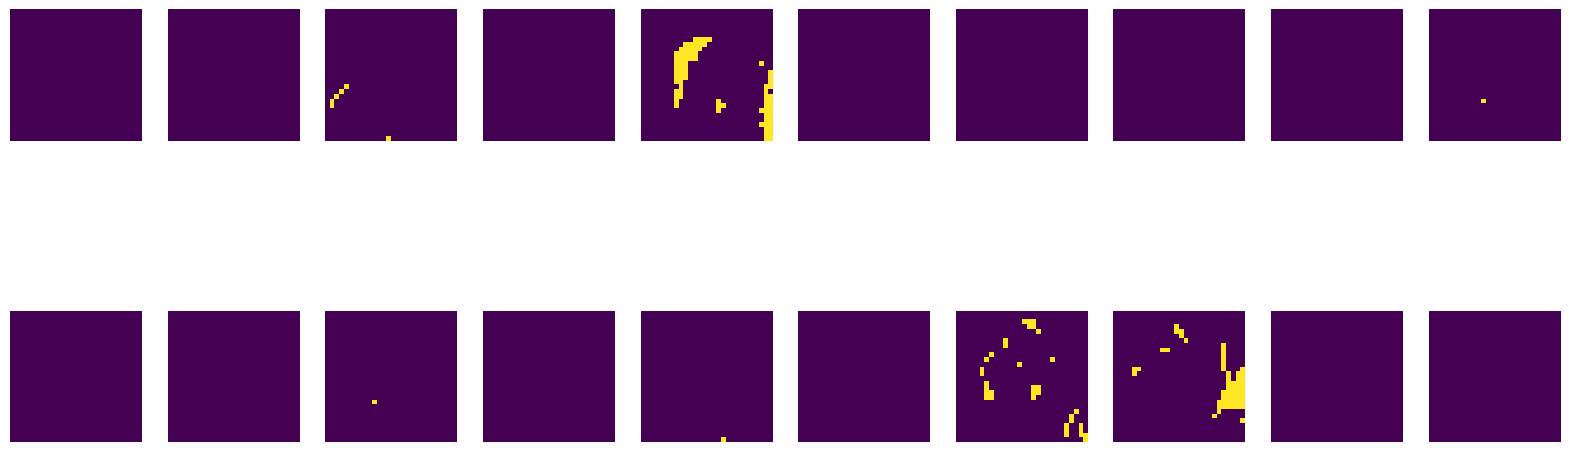

In [16]:
# Observing first 40 images
figure = plt.figure(figsize=(20,15))
num_of_images = 20
for index in range(1, num_of_images + 1):
    plt.subplot(4, 10, index)
    plt.axis('off')
    I = np.asarray(train_data.X).astype(np.float32).reshape(-1,28,28,1)[index]
    plt.imshow(I.astype('uint8'), )

In [17]:
data_iter = iter(trainloader)
images, labels = data_iter.next()
print(images.shape)
print(labels.shape)

torch.Size([180, 1, 28, 28])
torch.Size([180, 24])


In [18]:
model = BNN('SingLanguage', "relu", "custom", "svi", 5, 0.0007, None, None, (1,28,28), n_classes)
print(model)

BNN(
  (basenet): NN(
    (loss_func): CrossEntropyLoss()
    (model): Sequential(
      (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 512, kernel_size=(3, 3), stride=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Flatten(start_dim=1, end_dim=-1)
      (7): Linear(in_features=12800, out_features=256, bias=True)
      (8): Linear(in_features=256, out_features=24, bias=True)
    )
  )
)


In [19]:
pyro.clear_param_store()

In [20]:
model.train(trainloader, device, rel_path = None, filename = None)


 == SVI training ==


/home/thomas/miniconda3/envs/tyxe_lorzo/lib/python3.9/site-packages/pyro/primitives.py:491: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(
/home/thomas/miniconda3/envs/tyxe_lorzo/lib/python3.9/site-packages/torch/_tensor.py:1083: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1660070785140/work/build/aten/src/ATen/core/TensorBody.h:477.)
  return self._grad


ValueError: at site "module$$$model.0.weight", invalid log_prob shape
  Expected [], actual [64, 1, 5, 5]
  Try one of the following fixes:
  - enclose the batched tensor in a with pyro.plate(...): context
  - .to_event(...) the distribution being sampled
  - .permute() data dimensions

In [ ]:
import torch
x = torch.rand(5, 3)
print(x)

In [ ]:
torch.version.cuda


In [ ]:
!nvidia-smi

In [ ]:
import argparse
import os
#from savedir import *
#from utils import *
import numpy as np
import pandas as pd 
import copy

import torch
from torch import nn
import torch.nn.functional as nnf
import torch.optim as torchopt
import torch.distributions.constraints as constraints
softplus = torch.nn.Softplus()

import pyro
from pyro import poutine
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO, Predictive
import pyro.optim as pyroopt
from pyro.infer.mcmc import MCMC, HMC, NUTS
from pyro.distributions import OneHotCategorical, Normal, Categorical, Uniform
from pyro.nn import PyroModule

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

import random

/home/thomas/miniconda3/envs/tyxe_lorzo/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [ ]:
DEBUG = False

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))
if torch.cuda.is_available():
        torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
        torch.set_default_tensor_type('torch.FloatTensor')

Device: cuda:0


In [ ]:
def plot_loss_accuracy(dict, path):
    fig, (ax1, ax2) = plt.subplots(2, figsize=(12,8))
    ax1.plot(dict['loss'])
    ax1.set_title("loss")
    ax2.plot(dict['accuracy'])
    ax2.set_title("accuracy")
#    os.makedirs(os.path.dirname(path), exist_ok=True)
#    fig.savefig(path)

In [ ]:
class NN(nn.Module):

    def __init__(self, dataset_name, input_shape, output_size, activation, 
                 architecture, lr, epochs):

#        if math.log(hidden_size, 2).is_integer() is False or hidden_size<16:
#            raise ValueError("\nhidden size should be a power of 2 greater than 16.")

        super(NN, self).__init__()
        self.dataset_name = dataset_name
        self.loss_func = nn.CrossEntropyLoss()
        # self.loss_func = nn.NLLLoss()
        self.architecture = architecture
#        self.hidden_size = hidden_size
        self.output_size = output_size
        self.activation = activation
        self.lr, self.epochs = lr, epochs

#        self.name = self.get_name(dataset_name, hidden_size, activation, architecture, lr, epochs)
        self.set_model(architecture, activation, input_shape, output_size)
        # print("\nTotal number of weights =", sum(p.numel() for p in self.parameters()))

    def get_name(self, dataset_name, activation, architecture, lr, epochs):
        return str(dataset_name)+"_act="+str(activation)+\
               "_arch="+str(architecture)+"_ep="+str(epochs)+"_lr="+str(lr)

    def set_model(self, architecture, activation, input_shape, output_size):

        input_size = input_shape[0]*input_shape[1]*input_shape[2]
        in_channels = input_shape[0]
        n_classes = output_size

        if activation == "relu":
            activ = nn.ReLU
        elif activation == "leaky":
            activ = nn.LeakyReLU
        elif activation == "sigm":
            activ = nn.Sigmoid
        elif activation == "tanh":
            activ = nn.Tanh
        else: 
            raise AssertionError("\nWrong activation name.")

        if architecture == "fc":
            self.model = nn.Sequential(
                nn.Flatten(),
                nn.Linear(input_size, 100),
                activ(),
                nn.Linear(100, output_size))
            
        elif architecture == "custom":
            self.model = nn.Sequential(nn.Conv2d(in_channels= in_channels,
                                                 out_channels=64,
                                                 kernel_size=5,
                                                 ),
                                       activ(),
                                       nn.MaxPool2d(2,2),
                                       #nn.BatchNorm2d(64),
                                       nn.Conv2d(in_channels=64,
                                                 out_channels=512,
                                                 kernel_size=3,
                                                 ),
                                       activ(),
                                       nn.MaxPool2d(2,2),
                                       #nn.Dropout(p=0.3),
                                       #nn.Conv2d(in_channels=512,
                                       #          out_channels=1024,
                                       #          kernel_size=3,
                                       #          ),
                                       #activ(),
                                       #nn.MaxPool2d(2,2),
                                       #nn.BatchNorm2d(1024),
                                       #nn.Dropout(p=0.4),
                                       #nn.Conv2d(in_channels=1024,
                                       #          out_channels=1024,
                                       #          kernel_size=2,
                                       #          ),
                                       #activ(),
                                       #nn.MaxPool2d(2,2),
                                       #nn.Dropout(p=0.4),
                                       nn.Flatten(),
                                       nn.Linear(512*5*5, 256),
                                       #nn.Dropout(p=0.5),
                                       nn.Linear(256, output_size))

        elif architecture == "conv":

            if self.dataset_name not in ["mnist","fashion_mnist"]:
                raise NotImplementedError()

            self.model = nn.Sequential(
                nn.Conv2d(in_channels, 32, kernel_size=5),
                activ(),
                nn.MaxPool2d(kernel_size=2),
                nn.Conv2d(32, hidden_size, kernel_size=5),
                activ(),
                nn.MaxPool2d(kernel_size=2, stride=1),
                nn.Flatten(),
                nn.Linear(int(hidden_size/(4*4))*input_size, output_size))

        elif architecture == "conv2":

            self.model = nn.Sequential(

                nn.Conv2d(in_channels, 32, kernel_size=5),
                activ(),
                nn.MaxPool2d(kernel_size=2), 
                nn.Conv2d(32, hidden_size, kernel_size=5),
                activ(),
                nn.MaxPool2d(kernel_size=2, stride=1),
                nn.Flatten(),
            )   

            self.fc_out = lambda x: nn.Linear(x.size(1), output_size)(x)

        else:
            raise NotImplementedError()

    def forward(self, inputs, device=None, *args, **kwargs):

        device=self.device if device is None else device

        self.to(device)
        inputs = inputs.to(device)

        if self.architecture == "conv2":

            x = self.model(inputs)
            x = self.fc_out(x)

        else:
            x = self.model(inputs)

        return x

    def save(self, savedir=None, seed=None):

        name = self.name 
        directory = name if savedir is None else savedir
        filename = name+"_weights.pt" if seed is None else name+"_weights_"+str(seed)+".pt"

        os.makedirs(os.path.dirname(TESTS+directory+"/"), exist_ok=True)
        print("\nSaving: ", TESTS+directory+"/"+filename)
        torch.save(self.state_dict(), TESTS+directory+"/"+filename)

        if DEBUG:
            print("\nCheck saved weights:")
            print("\nstate_dict()['l2.0.weight'] =", self.state_dict()["l2.0.weight"][0,0,:3])
            print("\nstate_dict()['out.weight'] =",self.state_dict()["out.weight"][0,:3])

    def load(self, device, savedir=None, seed=None, rel_path = None):   #=TESTS
        self.device=device

        name = self.name
        directory = name if savedir is None else savedir
        filename = name+"_weights.pt" if seed is None else name+"_weights_"+str(seed)+".pt"

        print("\nLoading: ", rel_path+directory+"/"+filename)
        self.load_state_dict(torch.load(rel_path+directory+"/"+filename))
        print("\n", list(self.state_dict().keys()), "\n")
        self.to(device)

        if DEBUG:
            print("\nCheck loaded weights:")    
            print("\nstate_dict()['l2.0.weight'] =", self.state_dict()["l2.0.weight"][0,0,:3])
            print("\nstate_dict()['out.weight'] =",self.state_dict()["out.weight"][0,:3])

    def train(self, train_loader, device, seed=0, save=True):

        print("\n == NN training ==")

        self.device=device
        self.to(device)

        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
            torch.backends.cudnn.deterministic = True
            torch.backends.cudnn.benchmark = False

        optimizer = torchopt.Adam(params=self.parameters(), lr=self.lr)

#        start = time.time()
        for epoch in range(self.epochs):
            total_loss = 0.0
            correct_predictions = 0.0

            for x_batch, y_batch in train_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device).argmax(-1)
                
                optimizer.zero_grad()
                outputs = self.forward(x_batch, device)
                loss = self.loss_func(outputs, y_batch)
                loss.backward()
                optimizer.step()

                predictions = outputs.argmax(-1)
                correct_predictions += (predictions == y_batch).sum()
                total_loss += loss.item()

            total_loss = total_loss / len(train_loader.dataset)
            accuracy = 100 * correct_predictions / len(train_loader.dataset)
            print(f"\n[Epoch {epoch + 1}]\t loss: {total_loss:.8f} \t accuracy: {accuracy:.2f}", 
                  end="\t")

#        execution_time(start=start, end=time.time())
        
        if save:
            self.save()

    def evaluate(self, test_loader, device, *args, **kwargs):
        self.device=device
        self.to(device)

        with torch.no_grad():

            correct_predictions = 0.0

            for x_batch, y_batch in test_loader:

                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device).argmax(-1)
                outputs = self(x_batch)
                predictions = outputs.argmax(-1)
                correct_predictions += (predictions == y_batch).sum()

            accuracy = 100 * correct_predictions / len(test_loader.dataset)
            print("\nAccuracy: %.2f%%" % (accuracy))
            return accuracy

In [ ]:
class BNN(PyroModule):

    def __init__(self, dataset_name, activation, architecture, inference, 
                 epochs, lr, n_samples, warmup, input_shape, output_size, 
                 step_size=0.005, num_steps=10):
        super(BNN, self).__init__()
        self.dataset_name = dataset_name
        self.inference = inference
        self.architecture = architecture
        self.epochs = epochs
        self.lr = lr
        self.n_samples = n_samples
        self.warmup = warmup
        self.step_size = step_size
        self.num_steps = num_steps
        self.basenet = NN(dataset_name=dataset_name, input_shape=input_shape, output_size=output_size,
                          activation=activation, architecture=architecture, epochs=epochs, lr=lr)
        # print(self.basenet)
        self.name = self.get_name()

    def get_name(self, n_inputs=None):
        
        name = str(self.dataset_name)+"_bnn_"+str(self.inference)+"_act="+str(self.basenet.activation)+\
               "_arch="+str(self.basenet.architecture)

        if n_inputs:
            name = name+"_inp="+str(n_inputs)

        if self.inference == "svi":
            return name+"_ep="+str(self.epochs)+"_lr="+str(self.lr)
        elif self.inference == "hmc":
            return name+"_samp="+str(self.n_samples)+"_warm="+str(self.warmup)+\
                   "_stepsize="+str(self.step_size)+"_numsteps="+str(self.num_steps)

    def model(self, x_data, y_data):

        priors = {}
        for key, value in self.basenet.state_dict().items():
            loc = torch.zeros_like(value)
            scale = torch.ones_like(value)
            prior = Normal(loc=loc, scale=scale)
            priors.update({str(key):prior})

        lifted_module = pyro.random_module("module", self.basenet, priors)()

        with pyro.plate("data", len(x_data)):
            logits = lifted_module(x_data)
            lhat = nnf.log_softmax(logits, dim=-1)
            obs = pyro.sample("obs", Categorical(logits=lhat), obs=y_data)

    def guide(self, x_data, y_data=None):

        dists = {}
        for key, value in self.basenet.state_dict().items():
            loc = pyro.param(str(f"{key}_loc"), torch.randn_like(value)) 
            scale = pyro.param(str(f"{key}_scale"), torch.randn_like(value))
            distr = Normal(loc=loc, scale=softplus(scale))
            dists.update({str(key):distr})

        lifted_module = pyro.random_module("module", self.basenet, dists)()
        
        with pyro.plate("data", len(x_data)):
            logits = lifted_module(x_data)
            preds = nnf.softmax(logits, dim=-1)

        return preds

    def save(self, rel_path = None, filename=None):    #=TESTS

        if filename is None:
            filename = self.name+"_weights"

        path = rel_path + self.name +"/"
        os.makedirs(os.path.dirname(path), exist_ok=True)

        if self.inference == "svi":
            self.basenet.to("cpu")
            self.to("cpu")

            param_store = pyro.get_param_store()
            print("\nSaving: ", path + filename +".pt")
            print(f"\nlearned params = {param_store.get_all_param_names()}")
            param_store.save(path + filename +".pt")

        elif self.inference == "hmc":
            self.basenet.to("cpu")
            self.to("cpu")

            for key, value in self.posterior_predictive.items():
                torch.save(value.state_dict(), path+filename+"_"+str(key)+".pt")

                if DEBUG:
                    print(value.state_dict()["model.5.bias"])

    def load(self, device, rel_path = None, filename=None):     #=TESTS

        if filename is None:
            filename = self.name+"_weights"

        path = rel_path + self.name +"/"

        self.device=device
        self.basenet.device=device

        if self.inference == "svi":
            param_store = pyro.get_param_store()
            param_store.load(path + filename + ".pt")
            for key, value in param_store.items():
                param_store.replace_param(key, value.to(device), value)
            print("\nLoading ", path + filename + ".pt\n")

        elif self.inference == "hmc":

            self.posterior_predictive={}
            for model_idx in range(self.n_samples):
                net_copy = copy.deepcopy(self.basenet)
                net_copy.load_state_dict(torch.load(path+filename+"_"+str(model_idx)+".pt"))
                self.posterior_predictive.update({model_idx:net_copy})      

            if len(self.posterior_predictive)!=self.n_samples:
                raise AttributeError("wrong number of posterior models")

        self.to(device)
        self.basenet.to(device)

    def forward(self, inputs, n_samples=10, avg_posterior=False, seeds=None):

        if seeds:
            if len(seeds) != n_samples:
                raise ValueError("Number of seeds should match number of samples.")

        if self.inference == "svi":

            if avg_posterior is True:

                guide_trace = poutine.trace(self.guide).get_trace(inputs)  

                avg_state_dict = {}
                for key in self.basenet.state_dict().keys():
                    avg_weights = guide_trace.nodes[str(key)+"_loc"]['value']
                    avg_state_dict.update({str(key):avg_weights})

                self.basenet.load_state_dict(avg_state_dict)
                preds = [self.basenet.model(inputs)]

            else:

                preds = []  

                if seeds:
                    for seed in seeds:
                        pyro.set_rng_seed(seed)
                        guide_trace = poutine.trace(self.guide).get_trace(inputs)   
                        preds.append(guide_trace.nodes['_RETURN']['value'])

                else:

                    for _ in range(n_samples):
                        guide_trace = poutine.trace(self.guide).get_trace(inputs)   
                        preds.append(guide_trace.nodes['_RETURN']['value'])

                if DEBUG:
                    print("\nlearned variational params:\n")
                    print(pyro.get_param_store().get_all_param_names())
                    print(list(poutine.trace(self.guide).get_trace(inputs).nodes.keys()))
                    print("\n", pyro.get_param_store()["model.0.weight_loc"][0][:5])
                    print(guide_trace.nodes['module$$$model.0.weight']["fn"].loc[0][:5])
                    print("posterior sample: ", 
                      guide_trace.nodes['module$$$model.0.weight']['value'][5][0][0])

        elif self.inference == "hmc":

            preds = []
            posterior_predictive = list(self.posterior_predictive.values())

            if seeds is None:
                seeds = range(n_samples)

            for seed in seeds:
                net = posterior_predictive[seed]
                preds.append(net.forward(inputs))
    
        output_probs = torch.stack(preds).mean(0)
        return output_probs 

    def _train_hmc(self, train_loader, n_samples, warmup, step_size, num_steps, device, rel_path, filename):

        print("\n == HMC training ==")
        pyro.clear_param_store()

        num_batches = int(len(train_loader.dataset)/train_loader.batch_size)
        batch_samples = int(n_samples/num_batches)+1
        print("\nn_batches=",num_batches,"\tbatch_samples =", batch_samples)

        kernel = HMC(self.model, step_size=step_size, num_steps=num_steps)
        mcmc = MCMC(kernel=kernel, num_samples=batch_samples, warmup_steps=warmup, num_chains=1)

#        start = time.time()
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            labels = y_batch.to(device).argmax(-1)
            mcmc.run(x_batch, labels)

#        execution_time(start=start, end=time.time())     

        self.posterior_predictive={}
        posterior_samples = mcmc.get_samples(n_samples)
        state_dict_keys = list(self.basenet.state_dict().keys())

        if DEBUG:
            print("\n", list(posterior_samples.values())[-1])

        for model_idx in range(n_samples):
            net_copy = copy.deepcopy(self.basenet)

            model_dict=OrderedDict({})
            for weight_idx, weights in enumerate(posterior_samples.values()):
                model_dict.update({state_dict_keys[weight_idx]:weights[model_idx]})
            
            net_copy.load_state_dict(model_dict)
            self.posterior_predictive.update({str(model_idx):net_copy})

        if DEBUG:
            print("\n", weights[model_idx]) 

        self.save(rel_path=rel_path, filename=filename)

    def _train_svi(self, train_loader, epochs, lr, device, rel_path, filename):     # filename -> savedir
        self.device=device

        print("\n == SVI training ==")

        optimizer = pyro.optim.Adam({"lr":lr})
        elbo = TraceMeanField_ELBO()
        svi = SVI(self.model, self.guide, optimizer, loss=elbo)

        loss_list = []
        accuracy_list = []

#        start = time.time()
        for epoch in range(epochs):
            loss = 0.0
            correct_predictions = 0.0

            for x_batch, y_batch in train_loader:

                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                labels = y_batch.argmax(-1)
                loss += svi.step(x_data=x_batch, y_data=labels)

                outputs = self.forward(x_batch, n_samples=10)
                predictions = outputs.argmax(dim=-1)
                correct_predictions += (predictions == labels).sum().item()
            
            if DEBUG:
                print("\n", pyro.get_param_store()["model.0.weight_loc"][0][:5])
                print("\n", predictions[:10], "\n", labels[:10])

            total_loss = loss / len(train_loader.dataset)
            accuracy = 100 * correct_predictions / len(train_loader.dataset)

            print(f"\n[Epoch {epoch + 1}]\t loss: {total_loss:.2f} \t accuracy: {accuracy:.2f}", 
                  end="\t")

            loss_list.append(loss)
            accuracy_list.append(accuracy)

#        execution_time(start=start, end=time.time())
#        self.save(rel_path=rel_path, filename=filename)

        plot_loss_accuracy(dict={'loss':loss_list, 'accuracy':accuracy_list},
                           path = None)   # TESTS+self.name+"/"+self.name+"_training.png"

    def train(self, train_loader, device, rel_path = None, filename=None):   #=TESTS
        self.device=device
        self.basenet.device=device

        self.to(device)
        self.basenet.to(device)

        random.seed(0)
        pyro.set_rng_seed(0)

        if self.inference == "svi":
            self._train_svi(train_loader, self.epochs, self.lr, device, rel_path=rel_path, filename=filename)

        elif self.inference == "hmc":
            self._train_hmc(train_loader, self.n_samples, self.warmup,
                            self.step_size, self.num_steps, device, rel_path=rel_path, filename=filename)

    def evaluate(self, test_loader, device, n_samples=10, seeds_list=None):
        self.device=device
        self.basenet.device=device
        self.to(device)
        self.basenet.to(device)

        random.seed(0)
        pyro.set_rng_seed(0)

        bnn_seeds=list(range(n_samples)) if seeds_list is None else seeds_list

        with torch.no_grad():

            correct_predictions = 0.0
            for x_batch, y_batch in test_loader:

                x_batch = x_batch.to(device)
                outputs = self.forward(x_batch, n_samples=n_samples, seeds=bnn_seeds)
                predictions = outputs.argmax(-1)
                labels = y_batch.to(device).argmax(-1)
                correct_predictions += (predictions == labels).sum().item()

            accuracy = 100 * correct_predictions / len(test_loader.dataset)
            print("Accuracy: %.2f%%" % (accuracy))
            return accuracy

In [ ]:
data = pd.read_csv("data/sign_mnist_train.csv")

24


<AxesSubplot:ylabel='Frequency'>

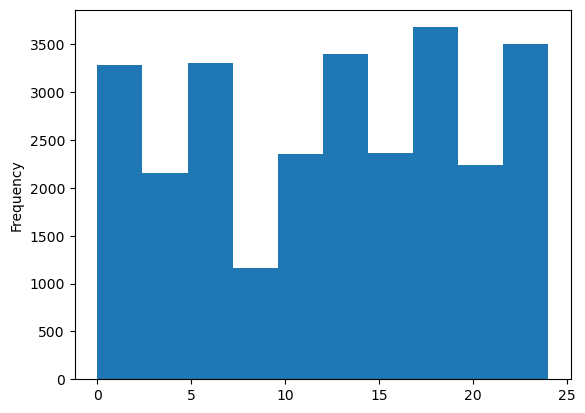

In [ ]:
n_classes = data["label"].nunique()
print(n_classes)
data["label"].plot.hist()

In [ ]:
y_train = data["label"]
X_train = data.drop(columns =["label"])

In [ ]:
# DATA PARSER AND LOADER FOR THE VALUES OF SKIN
class HandSignsDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = np.asarray(images).astype(np.float32)
        self.y = labels
        self.transforms = transforms
        #print("GUARDA QUI", self.y.shape)
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X[i, :]
        data = data.reshape(28, 28, 1)
       
        my_y = self.y.values[i]
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, my_y)
        else:
            return data

In [ ]:
y_train = pd.get_dummies(y_train)
X_train = X_train / 255
print(X_train)

         pixel1    pixel2    pixel3    pixel4    pixel5    pixel6    pixel7  \
0      0.419608  0.462745  0.498039  0.525490  0.545098  0.560784  0.572549   
1      0.607843  0.615686  0.611765  0.611765  0.611765  0.615686  0.611765   
2      0.733333  0.737255  0.737255  0.733333  0.733333  0.729412  0.733333   
3      0.827451  0.827451  0.831373  0.831373  0.827451  0.823529  0.827451   
4      0.643137  0.654902  0.666667  0.674510  0.690196  0.701961  0.705882   
...         ...       ...       ...       ...       ...       ...       ...   
27450  0.741176  0.741176  0.745098  0.745098  0.752941  0.756863  0.756863   
27451  0.592157  0.603922  0.615686  0.619608  0.627451  0.631373  0.639216   
27452  0.682353  0.682353  0.682353  0.682353  0.682353  0.686275  0.686275   
27453  0.694118  0.709804  0.721569  0.725490  0.733333  0.741176  0.745098   
27454  0.701961  0.705882  0.705882  0.705882  0.713725  0.709804  0.713725   

         pixel8    pixel9   pixel10  ...  pixel775 

In [ ]:
transform = transforms.Compose([ transforms.ToTensor(),
                                 transforms.Normalize(mean = 0.5, std = 0.5)])


train_data = HandSignsDataset(X_train, y_train, transform)
#test_data = HandSignsDataset(X_test, y_test, transform)
print(train_data)

In [ ]:
generator = torch.Generator(device=device)

In [ ]:
# dataloaders
trainloader = DataLoader(train_data, batch_size=180, shuffle=True, generator=generator)
#testloader = DataLoader(test_data, batch_size=8, shuffle=True)

In [ ]:
np.asarray(train_data.X).astype(np.float32)

array([[0.41960785, 0.4627451 , 0.49803922, ..., 0.8       , 0.79607844,
        0.7921569 ],
       [0.60784316, 0.6156863 , 0.6117647 , ..., 0.40392157, 0.5294118 ,
        0.58431375],
       [0.73333335, 0.7372549 , 0.7372549 , ..., 0.7647059 , 0.7607843 ,
        0.7647059 ],
       ...,
       [0.68235296, 0.68235296, 0.68235296, ..., 0.7921569 , 0.78431374,
        0.78431374],
       [0.69411767, 0.70980394, 0.72156864, ..., 0.2509804 , 0.34117648,
        0.3647059 ],
       [0.7019608 , 0.7058824 , 0.7058824 , ..., 0.8039216 , 0.81960785,
        0.84313726]], dtype=float32)

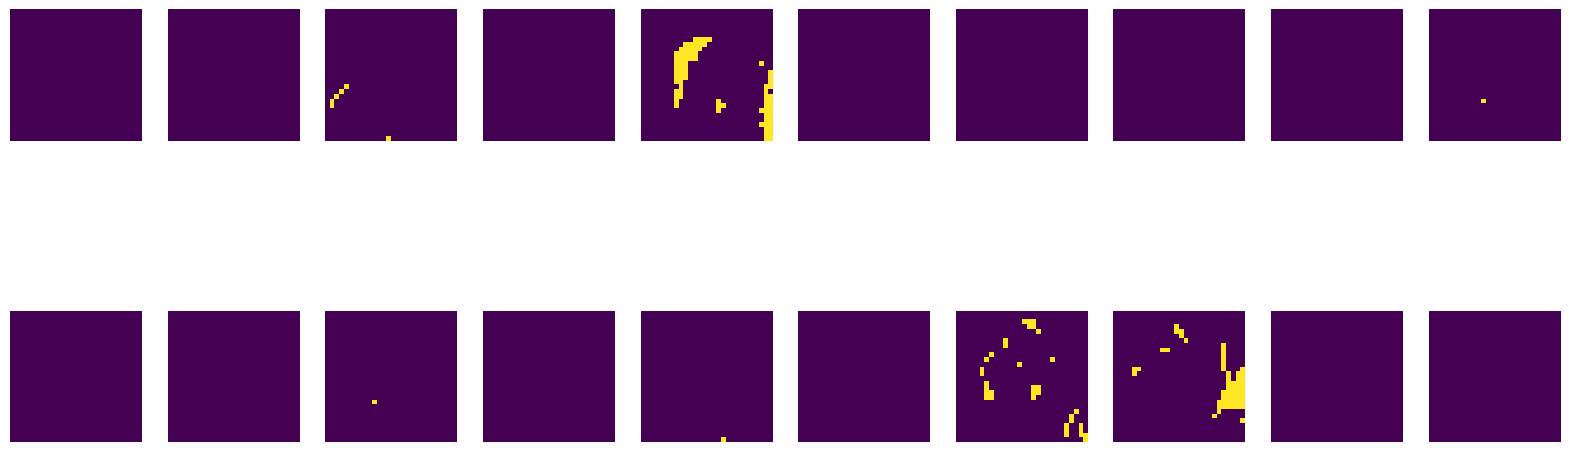

In [ ]:
# Observing first 40 images
figure = plt.figure(figsize=(20,15))
num_of_images = 20
for index in range(1, num_of_images + 1):
    plt.subplot(4, 10, index)
    plt.axis('off')
    I = np.asarray(train_data.X).astype(np.float32).reshape(-1,28,28,1)[index]
    plt.imshow(I.astype('uint8'), )

In [ ]:
data_iter = iter(trainloader)
images, labels = data_iter.next()
print(images.shape)
print(labels.shape)

torch.Size([180, 1, 28, 28])
torch.Size([180, 24])


In [ ]:
model = BNN('SingLanguage', "relu", "custom", "svi", 5, 0.0007, None, None, (1,28,28), n_classes)
print(model)

BNN(
  (basenet): NN(
    (loss_func): CrossEntropyLoss()
    (model): Sequential(
      (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 512, kernel_size=(3, 3), stride=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Flatten(start_dim=1, end_dim=-1)
      (7): Linear(in_features=12800, out_features=256, bias=True)
      (8): Linear(in_features=256, out_features=24, bias=True)
    )
  )
)


In [ ]:
pyro.clear_param_store()

In [ ]:
model.train(trainloader, device, rel_path = None, filename = None)


 == SVI training ==


/home/thomas/miniconda3/envs/tyxe_lorzo/lib/python3.9/site-packages/pyro/primitives.py:491: FutureWarning: The `random_module` primitive is deprecated, and will be removed in a future release. Use `pyro.nn.Module` to create Bayesian modules from `torch.nn.Module` instances.
  warnings.warn(
/home/thomas/miniconda3/envs/tyxe_lorzo/lib/python3.9/site-packages/torch/_tensor.py:1083: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1660070785140/work/build/aten/src/ATen/core/TensorBody.h:477.)
  return self._grad


ValueError: at site "module$$$model.0.weight", invalid log_prob shape
  Expected [], actual [64, 1, 5, 5]
  Try one of the following fixes:
  - enclose the batched tensor in a with pyro.plate(...): context
  - .to_event(...) the distribution being sampled
  - .permute() data dimensions

In [ ]:
import torch
x = torch.rand(5, 3)
print(x)

In [ ]:
torch.version.cuda


In [ ]:
!nvidia-smi